### Data wrangling

### User engagement data

In [118]:
# import libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# plt.style.use('fivethirtyeight') 
plt.style.use('seaborn')  
sns.set_theme(style="dark")
from sklearn.model_selection import train_test_split

C:\Users\tonya\AppData\Local\Temp\ipykernel_13148\2219300246.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [119]:
#read the user engagement data
df = pd.read_csv('takehome_user_engagement.csv')
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [120]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format( df['user_id'].nunique(), len(df)))

There were 8823 users and 207917 total logins


In [121]:
# convert time_stamp into datetime format
df['time_stamp'] = pd.to_datetime( df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [122]:
# function returning if a user has logged in on 3 seperate days in a 7-day period.
def adopted_func(df, days = 7, logins = 3):
   
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days = days))

In [123]:
# run the function on all users
adopted = engagement.groupby('user_id').apply(adopted_func)
adopted.name = 'adopted_user'

In [124]:
print('There have been {} adopted users out of {} users'.format( sum(adopted), len(adopted)))

There have been 1656 adopted users out of 8823 users


### User data

In [125]:
# read the user data
# some columns such as name, email address are not useful and we can omit them

cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv('takehome_users.csv', usecols= cols, encoding='Latin')
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [126]:
# 5 Organizations with most users
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [127]:
# 5 Users with most invites
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
1525.0     11
11770.0    11
2308.0     11
Name: invited_by_user_id, dtype: int64

In [128]:
# remove those two features
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

In [129]:
# create a feature of user history
# convert both time features into datetime
users['creation_time'] = pd.to_datetime( users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime( users['last_session_creation_time'], unit='s')

# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days

# drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis= 1)

In [130]:
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [131]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


In [132]:
# merge user data and "adopted user" variable
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis= 1, join= 'inner')
data['adopted_user'] = data['adopted_user'].astype(int)

## EDA

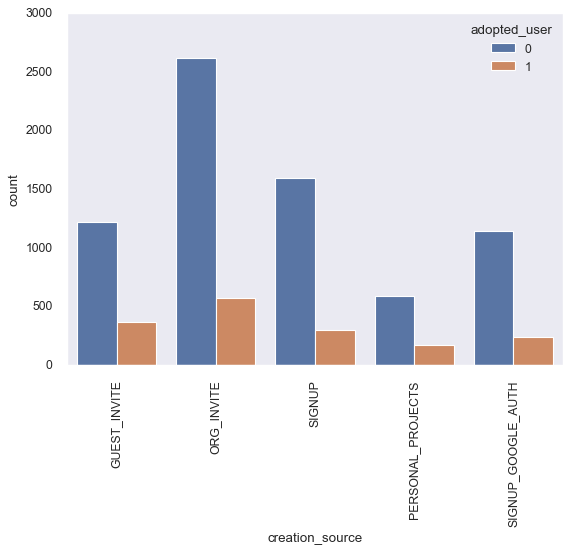

In [133]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

- It doesn't look like there is much difference among creation sources, with slight preference to ORG_INVITE

In [134]:
# let's do a chi2 test creation_source and adopted_user
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}   ----   p = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451   ----   p = 2.3526508745340972e-08


In [135]:
# how much was the difference
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x) / len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

- Slightly higher "adopted user" rate in guest_invite and personal_projects

In [136]:
data

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age,adopted_user
user_id,,,,,,
1,GUEST_INVITE,1,0,0.0,38,0
2,ORG_INVITE,0,0,136.0,196,1
3,ORG_INVITE,0,0,0.0,437,0
4,GUEST_INVITE,0,0,1.0,374,0
5,GUEST_INVITE,0,0,5.0,498,0
...,...,...,...,...,...,...
11996,ORG_INVITE,0,0,0.0,266,0
11997,SIGNUP_GOOGLE_AUTH,0,0,5.0,505,0
11998,GUEST_INVITE,1,1,0.0,33,0


In [137]:

# check mailing list and marketing drip
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x) / len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [138]:
# check mailing list and marketing drip
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x) / len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [139]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148219, p = 0.4820695142048773


In [140]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x) / len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [141]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940353, p = 0.6870022995069649


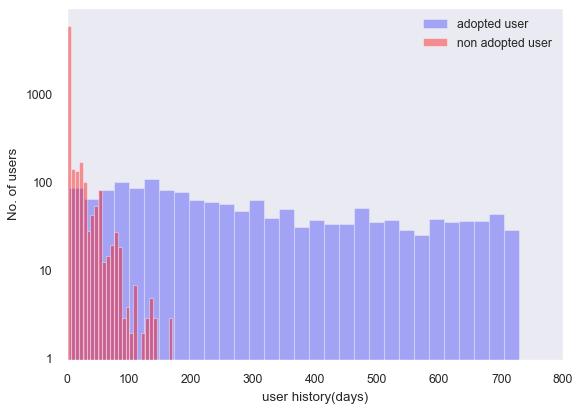

In [142]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user'] == 1, col],  bins=30, alpha=0.3, color='blue', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user'] == 0, col],  bins=30, alpha=0.4, color='red', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(data, 'history', 'user history(days)')
plt.style.use("bmh")

- Users with long history are more likely to be adopted users

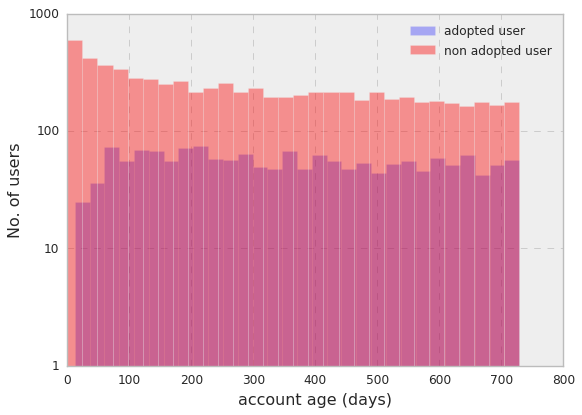

In [143]:
plot_hist_days(data, 'account_age', 'account age (days)')
plt.style.use("classic")

- Adoption rate is lower in very new accounts.

## Modeling

In [144]:
# make dummy variable for creation_source
creation_source = pd.get_dummies(data['creation_source'])    #  optional in this case makes no diff.  drop_first = True
model_data = pd.concat([data, creation_source], axis= 1).drop('creation_source', axis= 1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis= 1)

# though account_age and history have different scales than other features,
# we can use random forest model, which is not affected by different scales
# no need to scale the data
# create training and testing sets

Xtrain, Xtest, ytrain, ytest = train_test_split( X, y, stratify=y, random_state= 22)

In [145]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.9602543199219935


In [146]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9578422484134179
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1792
           1       0.91      0.86      0.88       414

    accuracy                           0.96      2206
   macro avg       0.94      0.92      0.93      2206
weighted avg       0.96      0.96      0.96      2206



In [147]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index= X.columns)
imp = imp.sort_values(ascending= False)
print(imp)

history                       0.895948
account_age                   0.085870
opted_in_to_mailing_list      0.003811
enabled_for_marketing_drip    0.003064
SIGNUP_GOOGLE_AUTH            0.002800
SIGNUP                        0.002431
GUEST_INVITE                  0.002399
ORG_INVITE                    0.002133
PERSONAL_PROJECTS             0.001544
dtype: float64


- Most important feature is user `history`. 
- Account_age follows, but proves no predictive value.
- opted_in_to_mailing_list and enabled_for_marketing_drip are close in importance, yet with low business value of significance to affect adoption.
- GUEST_INVITE and SIGNUP follow, probably as an incentive to try the service
- ORG_INVITE is slighly better then PERSONAL_PROJECTS signup, yet pretty low. 

### The entire set was imbalanced and most users were in the un-engaged class.
### Hard to give viable recomendations based on these datasets. Data with richer features is needed.
               